In [1]:
import hydra
import torch
from glob import  glob
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from proteoscope.data import ProteoscopeDM
from proteoscope.modules import AutoencoderLM, ProteoscopeLM


test = 'proteoscope' # proteoscope autoencoder

# BASE_DIR = f"/home/ec2-user/outputs/proteoscope/2023-08-22/07-18-31" # Best proteoscope - ESM-full
# BASE_DIR = f"/home/ec2-user/outputs/proteoscope/2023-08-22/07-24-27" # Best proteoscope - ESM-mean
BASE_DIR = "/home/ec2-user/outputs/proteoscope/2023-09-14/06-10-36" # Best proteoscope - ESM-full
# BASE_DIR = f"/home/ec2-user/outputs/autoencoder/2023-08-19/17-28-45" # Best autoencoder

protein_split = 'all_fov_' # '' or 'all_' or 'all_fov_
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1] #-1
    print('   Using ', chkpt)

    pdm = ProteoscopeDM(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        sequences_path=config.data.sequences_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
        trim=config.data.trim,
        sequence_embedding=config.data.sequence_embedding,
        splits=config.splits,
    )
    pdm.setup()

    if test == 'autoencoder':
        alm = AutoencoderLM.load_from_checkpoint(
            chkpt,
            module_config=config.module,
            strict=False,
        )

        alm.vae.to('cuda')
        alm.eval()
    elif test == 'proteoscope':
        plm = ProteoscopeLM.load_from_checkpoint(
            chkpt,
            module_config=config.module,
            strict=False,
        )

        plm.eval()
        plm.cuda()
    else:
        raise ValueError(f"Unrecognized option {test}")

/tmp/ipykernel_130486/2023863982.py:22: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs/proteoscope/2023-09-14/06-10-36/checkpoints/last.ckpt


/home/ec2-user/proteoscope/proteoscope/data/datamodule.py:43: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(self.labels_path, index_col=0)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:52: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.7, which is newer than your current Lightning version: v2.0.6
  rank_zero_warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [2]:
# from proteoscope.modules import CytoselfLM


# cytoself_checkpoint = '/home/ec2-user/outputs/cytoself/2023-09-02/05-17-26/checkpoints/last.ckpt'
# cytoself_config = config.module.copy()
# cytoself_config.model = config.module.model.cytoself.model
# plm.cytoself = CytoselfLM.load_from_checkpoint(
#     cytoself_checkpoint,
#     module_config=cytoself_config,
#     num_class=config.module.model.cytoself.num_class,
# ).model
# plm.cytoself.to('cuda')
# plm.cytoself.eval()

In [102]:
n = 3
a = ['a'] * n
b = ['M' * 300] * n

result = list(zip(a, b))
labels, strs, toks = plm.esm_converter(result)
toks = toks.to(plm.device)
out = plm.esm.model(toks, repr_layers=[33], return_contacts=False)


In [106]:
out[33]

KeyError: 33

In [101]:
plm.esm.model

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(
          in_features=1280, out_features=1280, bias=True
          (lora_dropout): ModuleDict(
            (default): Dropout(p=0.1, inplace=False)
          )
          (lora_A): ModuleDict(
            (default): Linear(in_features=1280, out_features=4, bias=False)
          )
          (lora_B): ModuleDict(
            (default): Linear(in_features=4, out_features=1280, bias=False)
          )
          (lora_embedding_A): ParameterDict()
          (lora_embedding_B): ParameterDict()
        )
        (v_proj): Linear(
          in_features=1280, out_features=1280, bias=True
          (lora_dropout): ModuleDict(
            (default): Dropout(p=0.1, inplace=False)
          )
          (lora_A): ModuleDict(
            (default): Linear(in_features=1280, out_features=4, bias=False)
          )
          (lora_B

In [90]:
next(plm.esm.parameters()).is_cuda

True

In [91]:
next(plm.esm.parameters())

Parameter containing:
tensor([[ 0.0536, -0.0583, -0.1300,  ..., -0.2219,  0.1180, -0.0660],
        [ 0.0614,  0.0292, -0.1028,  ..., -0.0330,  0.0668, -0.0575],
        [-0.0895, -0.0448, -0.0575,  ..., -0.0585,  0.0651, -0.1090],
        ...,
        [ 0.0023,  0.0143,  0.0514,  ..., -0.0193,  0.0112,  0.0053],
        [ 0.0731,  0.0470,  0.0346,  ...,  0.1118,  0.0465, -0.0243],
        [ 0.0492,  0.0254, -0.1112,  ..., -0.0257,  0.0599, -0.0614]],
       device='cuda:0')

In [89]:
plm.esm

AttributeError: 'ESM2' object has no attribute 'device'

## Reconstruct val images

In [3]:
# dl = pdm.val_dataloader()
dl = pdm.custom_dataloader(split_images='val', split_protein='val', shuffle=42, downsample=10, batch_size=16)

In [4]:
import torch
from tqdm import tqdm
import numpy as np
from piqa import SSIM, PSNR
from torchmetrics.image.fid import FrechetInceptionDistance

gs = 3.0
nis = 50

ssim = SSIM(n_channels=1).to('cuda')
psnr = PSNR().to('cuda')
fid_pro = FrechetInceptionDistance(normalize=True).to('cuda')
fid_nuc = FrechetInceptionDistance(normalize=True).to('cuda')

index = []
input_images = []
output_images = []
input_cytoself_embeds = []
output_cytoself_embeds = []
input_autoencoder_embeds = []
input_cytoself_logits = []
output_cytoself_logits = []
diffused_autoencoder_embeds = []

ssim_scores_pro = []
ssim_scores_nuc = []
psnr_scores_pro = []
psnr_scores_nuc = []

with torch.no_grad():
    for batch in tqdm(dl):
        batch['image'] = batch['image'].to('cuda')
        if 'sequence_embed' in batch.keys():
            batch['sequence_embed'] = batch['sequence_embed'].to('cuda')
            batch['sequence_mask'] = batch['sequence_mask'].to('cuda')
        
        input_image = batch['image']
        input_cytoself_embed = plm.cytoself(input_image, 'vqvec2')
        _, input_cytoself_logit = plm.cytoself(input_image)

        if test == 'autoencoder':
            output_image, _, input_autoencoder_embed = alm(input_image, return_embed=True, sample_posterior=False)
            diffused_autoencoder_embed = torch.empty(0)
        elif test == 'proteoscope':
            diffused_autoencoder_embed = plm.sample(batch, guidance_scale=gs, cond_images=None, num_inference_steps=nis, seed=42)
            output_image = plm.autoencoder.decode(diffused_autoencoder_embed).sample
            input_autoencoder_embed = plm.autoencoder.encode(batch['image']).latent_dist.mean

        output_image = output_image.clip(0, 1)
        output_cytoself_embed = plm.cytoself(output_image, 'vqvec2')
        _, output_cytoself_logit = plm.cytoself(output_image)

        ssim_pro = ssim(input_image[:, 0].unsqueeze_(1), torch.clip(output_image[:, 0].unsqueeze_(1), 0, 1))
        ssim_nuc = ssim(input_image[:, 1].unsqueeze_(1), torch.clip(output_image[:, 1].unsqueeze_(1), 0, 1))

        psnr_pro = psnr(input_image[:, 0].unsqueeze_(1), torch.clip(output_image[:, 0].unsqueeze_(1), 0, 1))
        psnr_nuc = psnr(input_image[:, 1].unsqueeze_(1), torch.clip(output_image[:, 1].unsqueeze_(1), 0, 1))

        fid_pro.update(input_image[:, 0].unsqueeze_(1).tile(1, 3, 1, 1), real=True)
        fid_pro.update(torch.clip(output_image[:, 0].unsqueeze_(1), 0, 1).tile(1, 3, 1, 1), real=False)

        fid_nuc.update(input_image[:, 1].unsqueeze_(1).tile(1, 3, 1, 1), real=True)
        fid_nuc.update(torch.clip(output_image[:, 1].unsqueeze_(1), 0, 1).tile(1, 3, 1, 1), real=False)

        index.append(batch['index'].detach().cpu().numpy())
        ssim_scores_pro.append([ssim_pro.detach().cpu().numpy()])
        ssim_scores_nuc.append([ssim_nuc.detach().cpu().numpy()])
        psnr_scores_pro.append([psnr_pro.detach().cpu().numpy()])
        psnr_scores_nuc.append([psnr_nuc.detach().cpu().numpy()])
        input_images.append(input_image.detach().cpu().numpy())
        output_images.append(output_image.detach().cpu().numpy())
        input_cytoself_embeds.append(input_cytoself_embed.detach().cpu().numpy())
        output_cytoself_embeds.append(output_cytoself_embed.detach().cpu().numpy())
        input_autoencoder_embeds.append(input_autoencoder_embed.detach().cpu().numpy())
        input_cytoself_logits.append(input_cytoself_logit.detach().cpu().numpy())
        output_cytoself_logits.append(output_cytoself_logit.detach().cpu().numpy())
        diffused_autoencoder_embeds.append(diffused_autoencoder_embed.detach().cpu().numpy())

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  1%|▏         | 1/77 [00:13<16:52, 13.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  3%|▎         | 2/77 [00:23<14:05, 11.28s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  4%|▍         | 3/77 [00:33<13:07, 10.64s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  5%|▌         | 4/77 [00:42<12:34, 10.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  6%|▋         | 5/77 [00:52<12:12, 10.17s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  8%|▊         | 6/77 [01:02<11:54, 10.07s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  9%|▉         | 7/77 [01:12<11:39, 10.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 10%|█         | 8/77 [01:22<11:27,  9.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 12%|█▏        | 9/77 [01:32<11:16,  9.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 13%|█▎        | 10/77 [01:42<11:04,  9.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 14%|█▍        | 11/77 [01:52<10:54,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 16%|█▌        | 12/77 [02:01<10:43,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 17%|█▋        | 13/77 [02:11<10:33,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 18%|█▊        | 14/77 [02:21<10:23,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 19%|█▉        | 15/77 [02:31<10:13,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 21%|██        | 16/77 [02:41<10:03,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 22%|██▏       | 17/77 [02:51<09:54,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 23%|██▎       | 18/77 [03:01<09:44,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 25%|██▍       | 19/77 [03:11<09:34,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 26%|██▌       | 20/77 [03:21<09:24,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 27%|██▋       | 21/77 [03:31<09:14,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 29%|██▊       | 22/77 [03:40<09:04,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 30%|██▉       | 23/77 [03:50<08:55,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 31%|███       | 24/77 [04:00<08:45,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 32%|███▏      | 25/77 [04:10<08:35,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 34%|███▍      | 26/77 [04:20<08:25,  9.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 35%|███▌      | 27/77 [04:30<08:16,  9.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 36%|███▋      | 28/77 [04:40<08:06,  9.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 38%|███▊      | 29/77 [04:50<07:56,  9.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 39%|███▉      | 30/77 [05:00<07:46,  9.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 40%|████      | 31/77 [05:10<07:36,  9.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 42%|████▏     | 32/77 [05:20<07:26,  9.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 43%|████▎     | 33/77 [05:30<07:16,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|████▍     | 34/77 [05:39<07:05,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 45%|████▌     | 35/77 [05:49<06:56,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 47%|████▋     | 36/77 [05:59<06:46,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 48%|████▊     | 37/77 [06:09<06:36,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 49%|████▉     | 38/77 [06:19<06:26,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 51%|█████     | 39/77 [06:29<06:16,  9.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 52%|█████▏    | 40/77 [06:39<06:07,  9.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 53%|█████▎    | 41/77 [06:49<05:56,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 55%|█████▍    | 42/77 [06:59<05:46,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 56%|█████▌    | 43/77 [07:09<05:36,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 57%|█████▋    | 44/77 [07:19<05:26,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 58%|█████▊    | 45/77 [07:28<05:17,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|█████▉    | 46/77 [07:38<05:07,  9.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 61%|██████    | 47/77 [07:48<04:57,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 62%|██████▏   | 48/77 [07:58<04:47,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 64%|██████▎   | 49/77 [08:08<04:37,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 65%|██████▍   | 50/77 [08:18<04:27,  9.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 66%|██████▌   | 51/77 [08:28<04:17,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 68%|██████▊   | 52/77 [08:38<04:07,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 69%|██████▉   | 53/77 [08:48<03:57,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|███████   | 54/77 [08:58<03:47,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 71%|███████▏  | 55/77 [09:08<03:38,  9.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 73%|███████▎  | 56/77 [09:18<03:28,  9.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 74%|███████▍  | 57/77 [09:27<03:18,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 75%|███████▌  | 58/77 [09:37<03:08,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 77%|███████▋  | 59/77 [09:47<02:58,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 78%|███████▊  | 60/77 [09:57<02:48,  9.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 79%|███████▉  | 61/77 [10:07<02:38,  9.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 81%|████████  | 62/77 [10:17<02:28,  9.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 82%|████████▏ | 63/77 [10:27<02:18,  9.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 83%|████████▎ | 64/77 [10:37<02:08,  9.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 84%|████████▍ | 65/77 [10:47<01:58,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 86%|████████▌ | 66/77 [10:56<01:48,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 87%|████████▋ | 67/77 [11:06<01:39,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 88%|████████▊ | 68/77 [11:16<01:29,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 90%|████████▉ | 69/77 [11:26<01:19,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 91%|█████████ | 70/77 [11:36<01:09,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 92%|█████████▏| 71/77 [11:46<00:59,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 94%|█████████▎| 72/77 [11:56<00:49,  9.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 95%|█████████▍| 73/77 [12:06<00:39,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 96%|█████████▌| 74/77 [12:16<00:29,  9.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 97%|█████████▋| 75/77 [12:26<00:19,  9.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 99%|█████████▊| 76/77 [12:36<00:09,  9.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 77/77 [12:42<00:00,  9.91s/it]


In [5]:
fid_pro_score = fid_pro.compute()
fid_nuc_score = fid_nuc.compute()

In [6]:
index = np.concatenate(index, axis=0)
ssim_scores_pro = np.concatenate(ssim_scores_pro, axis=0)
ssim_scores_nuc = np.concatenate(ssim_scores_nuc, axis=0)
psnr_scores_pro = np.concatenate(psnr_scores_pro, axis=0)
psnr_scores_nuc = np.concatenate(psnr_scores_nuc, axis=0)

In [7]:
input_images = np.concatenate(input_images, axis=0)
output_images = np.concatenate(output_images, axis=0)
input_cytoself_embeds = np.concatenate(input_cytoself_embeds, axis=0)
input_autoencoder_embeds = np.concatenate(input_autoencoder_embeds, axis=0)
diffused_autoencoder_embeds = np.concatenate(diffused_autoencoder_embeds, axis=0)

In [8]:
input_cytoself_logits = np.concatenate(input_cytoself_logits, axis=0)
output_cytoself_logits = np.concatenate(output_cytoself_logits, axis=0)
output_cytoself_embeds = np.concatenate(output_cytoself_embeds, axis=0)

In [9]:
# tmp_path = '/home/ec2-user/cytoself-data/tmp/full'

# np.save(f'{tmp_path}/index.npy', index)
# np.save(f'{tmp_path}/ssim_scores_pro.npy', ssim_scores_pro)
# np.save(f'{tmp_path}/ssim_scores_nuc.npy', ssim_scores_nuc)
# np.save(f'{tmp_path}/psnr_scores_pro.npy', psnr_scores_pro)
# np.save(f'{tmp_path}/psnr_scores_nuc.npy', psnr_scores_nuc)


# np.save(f'{tmp_path}/input_images.npy', input_images)
# np.save(f'{tmp_path}/output_images.npy', output_images)
# np.save(f'{tmp_path}/input_cytoself_embeds.npy', input_cytoself_embeds)
# np.save(f'{tmp_path}/input_autoencoder_embeds.npy', input_autoencoder_embeds)
# np.save(f'{tmp_path}/diffused_autoencoder_embeds.npy', diffused_autoencoder_embeds)

# np.save(f'{tmp_path}/input_cytoself_logits.npy', input_cytoself_logits)
# np.save(f'{tmp_path}/output_cytoself_logits.npy', output_cytoself_logits)
# np.save(f'{tmp_path}/output_cytoself_embeds.npy', output_cytoself_embeds)

In [10]:
# index = np.load(f'{tmp_path}/index.npy')
# ssim_scores_pro = np.load(f'{tmp_path}/ssim_scores_pro.npy')
# ssim_scores_nuc = np.load(f'{tmp_path}/ssim_scores_nuc.npy')
# psnr_scores_pro = np.load(f'{tmp_path}/psnr_scores_pro.npy')
# psnr_scores_nuc = np.load(f'{tmp_path}/psnr_scores_nuc.npy')


# input_images = np.load(f'{tmp_path}/input_images.npy')
# output_images = np.load(f'{tmp_path}/output_images.npy')
# input_cytoself_embeds = np.load(f'{tmp_path}/input_cytoself_embeds.npy')
# input_autoencoder_embeds = np.load(f'{tmp_path}/input_autoencoder_embeds.npy')
# diffused_autoencoder_embeds = np.load(f'{tmp_path}/diffused_autoencoder_embeds.npy')

# input_cytoself_logits = np.load(f'{tmp_path}/input_cytoself_logits.npy')
# output_cytoself_logits = np.load(f'{tmp_path}/output_cytoself_logits.npy')
# output_cytoself_embeds = np.load(f'{tmp_path}/output_cytoself_embeds.npy')

In [11]:
print(len(input_images))

1226


In [12]:
true_names = np.array(pdm.labels['name'])[index]
true_localizations = np.array(pdm.labels['localization'])[index]
true_labels = np.array(pdm.labels['label'])[index]

In [13]:
np.mean(input_autoencoder_embeds)

0.07063526

In [14]:
np.std(input_autoencoder_embeds)

2.9003131

In [15]:
print(input_autoencoder_embeds.max())
print(input_autoencoder_embeds.min())

9.320484
-8.787707


In [16]:
print(fid_pro_score)
print(fid_nuc_score)

tensor(44.3484, device='cuda:0')
tensor(20.1513, device='cuda:0')


In [17]:
print(ssim_scores_pro.mean())
print(ssim_scores_nuc.mean())

0.4229177
0.5179014


In [18]:
print(psnr_scores_pro.mean())
print(psnr_scores_nuc.mean())

20.064253
20.005884


In [19]:
input_cytoself_labels = input_cytoself_logits.argmax(axis=1)
output_cytoself_labels = output_cytoself_logits.argmax(axis=1)

Accuracy 0.49592169657422513


/tmp/ipykernel_130486/3474189015.py:13: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1)[:, None]


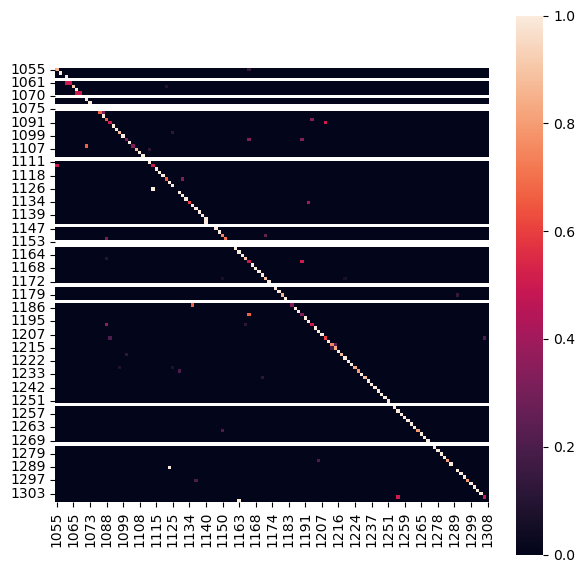

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = np.unique(true_labels)
# class_labels = range(num_class)

acc = accuracy_score(true_labels, input_cytoself_labels)
print(f'Accuracy {acc}')

cm = confusion_matrix(true_labels, input_cytoself_labels, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=False, fmt=".2f");

Accuracy 0.0024469820554649264


/tmp/ipykernel_130486/2910221747.py:5: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1)[:, None]


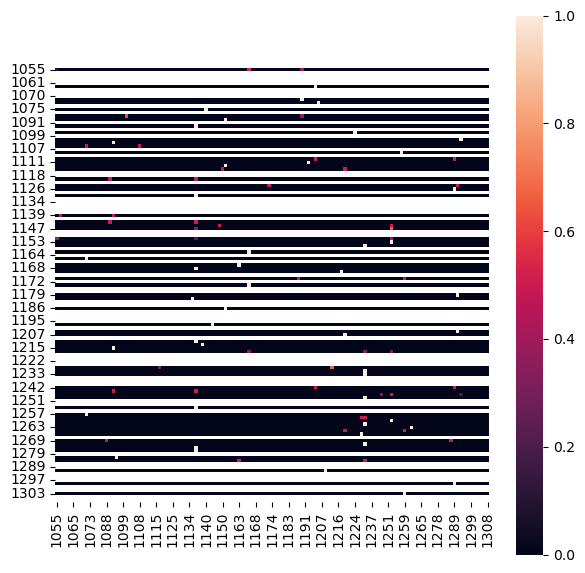

In [21]:
acc = accuracy_score(true_labels, output_cytoself_labels)
print(f'Accuracy {acc}')

cm = confusion_matrix(true_labels, output_cytoself_labels, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=False, fmt=".2f");

In [22]:
def top_k_accuracy(y_true, y_score, k=5):
    # Get the indices of the top k predicted classes for each sample
    top_k_preds = np.argsort(y_score, axis=1)[:, -k:]
    
    # Check if the true class is among the top k for each sample
    correct = np.any(top_k_preds == y_true[:, np.newaxis], axis=1)

    # Calculate the mean accuracy
    top_k_acc = np.mean(correct)
    
    return top_k_acc

In [23]:
input_classification_scores = [top_k_accuracy(true_labels, input_cytoself_logits, k=k) for k in range(1, 131)]

In [24]:
output_classification_scores = [top_k_accuracy(true_labels, output_cytoself_logits, k=k) for k in range(1, 131)]

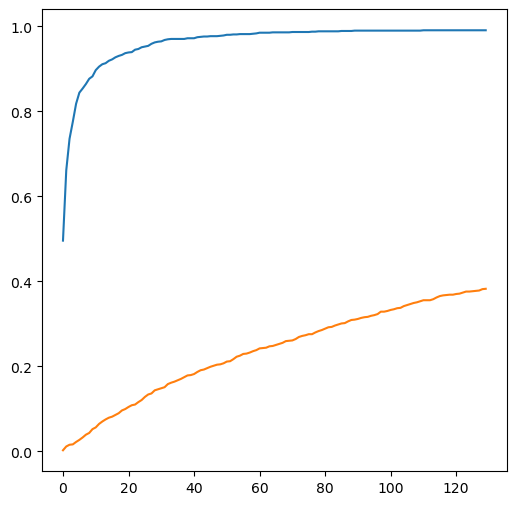

In [25]:
plt.figure(figsize=(6, 6));
plt.plot(input_classification_scores);
plt.plot(output_classification_scores);
# plt.plot(output_classification_scores_cache_3_0_25);
# plt.plot(output_classification_scores_cache_3_0_50);

In [26]:
print(input_classification_scores[13])
print(output_classification_scores[13])

print(input_classification_scores[-1])
print(output_classification_scores[-1])

0.9135399673735726
0.07504078303425775
0.9910277324632952
0.3825448613376835


In [27]:
import numpy as np
from collections import defaultdict
from scipy.special import softmax


def average_rows(arr, M):
    N = arr.shape[0]

    if M > N:
        raise ValueError("M must be less than or equal to N")

    # Create a random permutation of the rows
    permuted_indices = np.random.permutation(N)[: (N // M) * M]

    # Reshape the permuted indices to create groups of M rows
    groups_of_M = permuted_indices.reshape(N // M, M)

    # Average each group to produce N/M averages of M rows
    averaged_rows = [np.mean(arr[group], axis=0) for group in groups_of_M]

    return np.array(averaged_rows)


def average_logits_prediction(groups, labels, logits, M):
    logits_by_groups = defaultdict(list)
    label_by_groups = dict()
    for logit, group, label in zip(logits, groups, labels):
        logits_by_groups[group].append(logit)
        label_by_groups[group] = label

    n_pred = 0
    sum_pred = 0
    for key, logits in logits_by_groups.items():
        # logits = softmax(logits, axis=1)
        if M <= len(logits):
            averaged_predictions = average_rows(np.array(logits), M).argmax(axis=1)
            target = label_by_groups[key]
            sum_pred = sum_pred + (averaged_predictions == target).sum()
            n_pred = n_pred + len(averaged_predictions)

    return sum_pred / n_pred

In [28]:
num_avg = 8
input_classification_scores_avg = [average_logits_prediction(true_labels, true_labels, input_cytoself_logits, M=k) for k in range(1, num_avg)]

In [29]:
output_classification_scores_avg = [average_logits_prediction(true_labels, true_labels, output_cytoself_logits, M=k) for k in range(1, num_avg)]

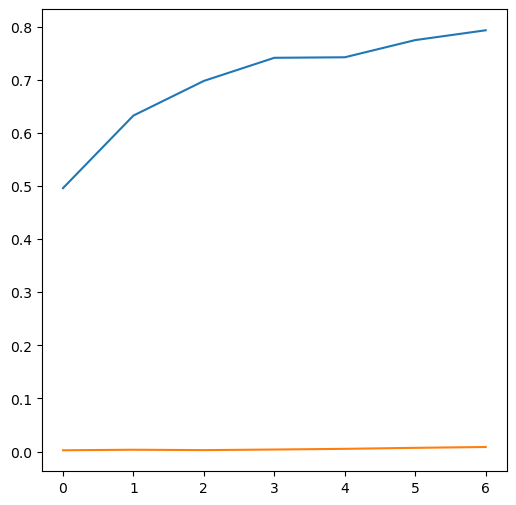

In [30]:
plt.figure(figsize=(6, 6));
plt.plot(input_classification_scores_avg);
plt.plot(output_classification_scores_avg);

In [31]:
print(input_classification_scores_avg[-1])
print(output_classification_scores_avg[-1])

0.7931034482758621
0.008620689655172414


In [32]:
print((true_labels == input_cytoself_logits.argmax(axis=1)).mean())
print((true_labels == output_cytoself_logits.argmax(axis=1)).mean())

0.49592169657422513
0.0024469820554649264


In [33]:
def cross_entropy_loss(y_true, logits, eps=1e-20):
    # Compute the softmax activation
    exp_logits = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
    softmax_probs = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

    # Gather the probabilities corresponding to the true labels
    true_probs = softmax_probs[np.arange(len(y_true)), y_true]

    # Compute the cross-entropy loss
    loss = -np.mean(np.log(true_probs + eps))

    return loss

In [34]:
print(cross_entropy_loss(true_labels, input_cytoself_logits))
print(cross_entropy_loss(true_labels, output_cytoself_logits))

2.186375
21.149586


In [35]:
print(np.mean((input_cytoself_embeds - output_cytoself_embeds)**2))

0.6139772


## Images

In [36]:
# FID ↓ IS ↑ PSNR ↑ SSIM ↑
# FCD, CS ....

In [37]:
from proteoscope.plotting import browse_reconstructions, merge_prot_nuc

In [38]:
# ['AKAP13' 'AMBRA1' 'ARFGAP2' 'ARHGAP35' 'CAMK1' 'CCT7' 'CD9' 'CEP135'
#  'CEPT1' 'CHM' 'DDX47' 'ECT2' 'FASN' 'FAU' 'GATAD1' 'HEATR3' 'IKBKB'
#  'LDHB' 'NCAPH' 'PACSIN2' 'PHLDB1' 'PPP2CA' 'RABGGTA' 'RANBP9' 'RPL13'
#  'SCAMP1' 'SLC23A2' 'SLC27A4' 'SLC4A2' 'SNF8' 'SNUPN' 'TUBA1B' 'USP1'
#  'VAPB' 'VRK2']

In [39]:
browse_reconstructions(input_images[:, 0], output_images[:, 0], true_names)

interactive(children=(Dropdown(description='name', options=('AGAP1', 'AKAP13', 'AKT2', 'AMBRA1', 'ANAPC11', 'A…

## Merged nuclei view

In [40]:
true_merged = merge_prot_nuc(input_images[:1000], percentiles=[0.1, 99.9])
predicted_merged = merge_prot_nuc(output_images[:1000], percentiles=[0.1, 99.9])
true_names_merged = true_names[:1000]

In [41]:
browse_reconstructions(true_merged, predicted_merged, true_names_merged)

interactive(children=(Dropdown(description='name', options=('AGAP1', 'AKAP13', 'AKT2', 'AMBRA1', 'ANAPC11', 'A…

## Visualize in cytoself umap

In [42]:
import zarr
from os.path import join
import numpy as np

datapath = "/home/ec2-user/cytoself-data/results"

In [43]:
zarr_path = join(datapath, f"cytoself_{protein_split}embeddings_vqvec2.zarr")

embeddings = np.asarray(zarr.open(zarr_path, mode='r'))
# localizations = np.load(join(datapath, "good_localizations_redo21.npy"))
# names = np.load(join(datapath, "good_names_redo21.npy"))
# complexes = np.load(join(datapath, "good_complexes_redo21.npy"))
# complexes_fig = np.load(join(datapath, "good_complexes_fig_redo21.npy"))


In [44]:
if protein_split == '':
    labels = pdm.labels[np.logical_and(pdm.labels['split_images_fov'] == 'val', pdm.labels['split_protein'] == 'train')]
elif protein_split == 'all_':
    labels = pdm.labels[pdm.labels['split_images'] == 'val']
else:
    labels = pdm.labels[pdm.labels['split_images_fov'] == 'val']

names = np.array(labels['name'])
localizations = np.array(labels['localization'])
complexes = np.array(labels['complex'])
complexes_fig = np.array(labels['complex_fig'])

shuffle = np.load(join(datapath, "cytoself_all_fov_embeddings_shuffle.npy"))
names = names[shuffle]
localizations = localizations[shuffle]
complexes = complexes[shuffle]
complexes_fig = complexes_fig[shuffle]

In [45]:
print(embeddings.max())
print(embeddings.min())

print(input_cytoself_embeds.max())
print(input_cytoself_embeds.min())

print(output_cytoself_embeds.max())
print(output_cytoself_embeds.min())

3.3475818634033203
-0.24840334057807922
3.3475816
-0.24840333
3.3475816
-0.24840333


In [46]:
from joblib import load

reducer = load(join(datapath, f'cytoself_{protein_split}umap_model.joblib'))

In [47]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))

In [48]:
reduced_input_cytoself_embeds = reducer.transform(input_cytoself_embeds.reshape(input_cytoself_embeds.shape[0], -1))
reduced_output_cytoself_embeds = reducer.transform(output_cytoself_embeds.reshape(output_cytoself_embeds.shape[0], -1))

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

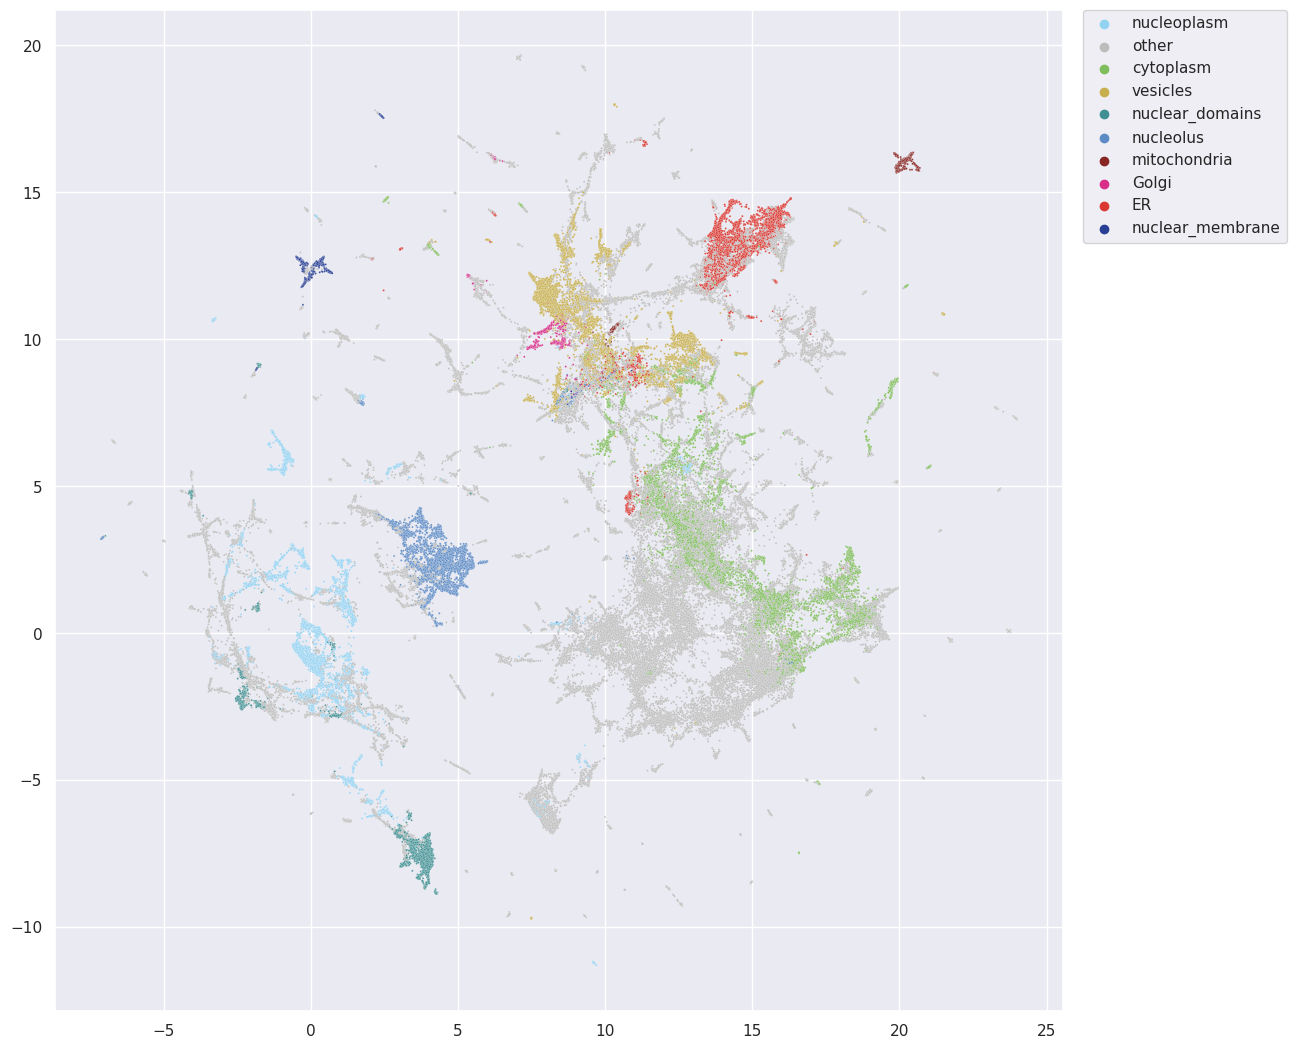

In [51]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

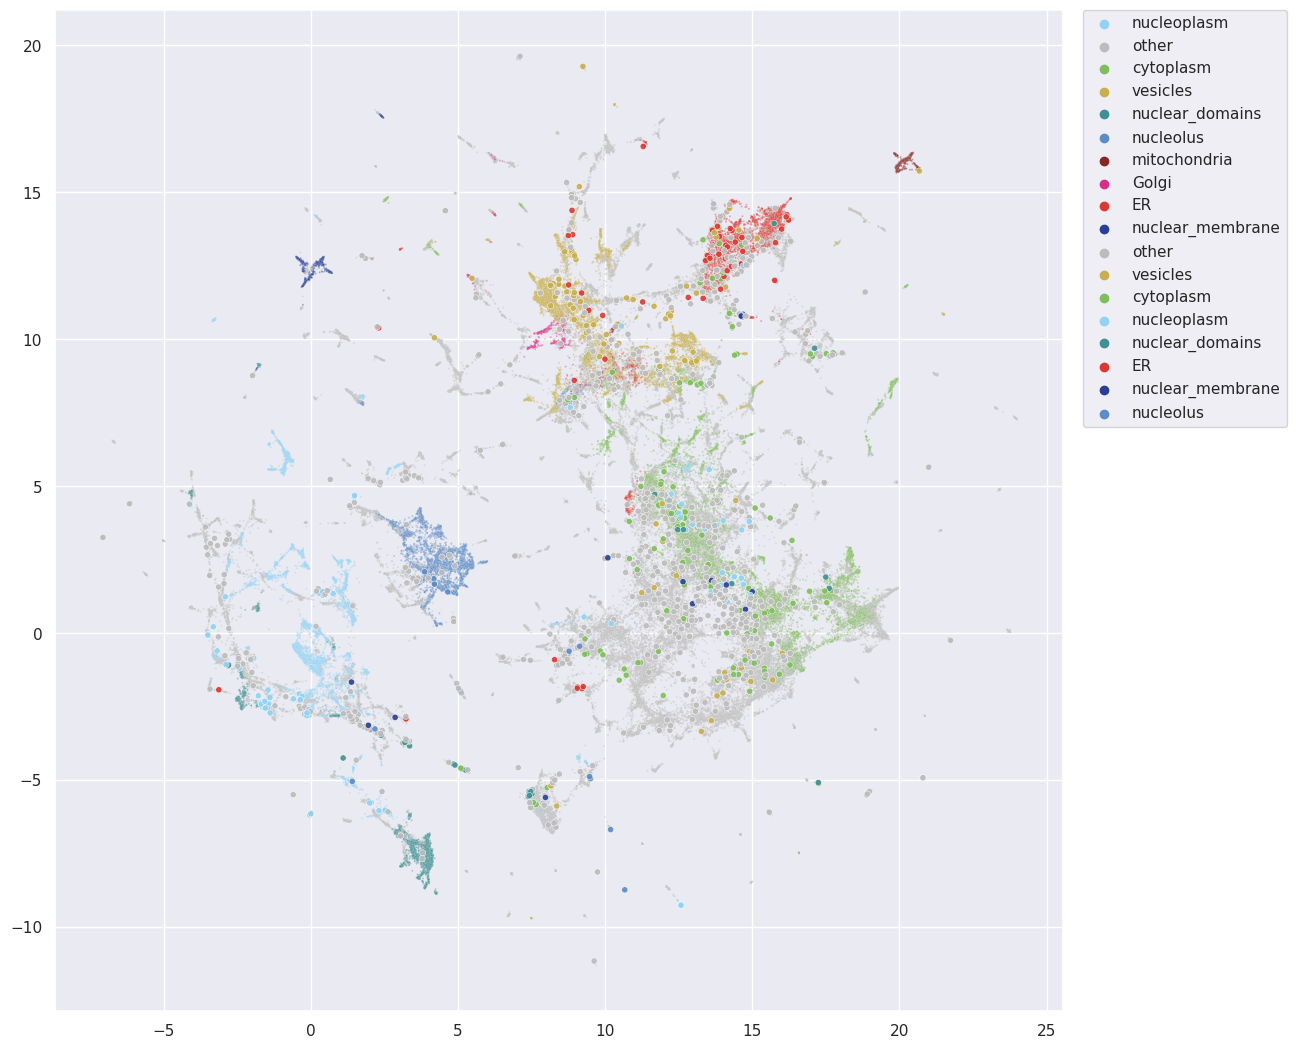

In [52]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_output_cytoself_embeds[:, 0], y=reduced_output_cytoself_embeds[:, 1], hue=true_localizations, s=20, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

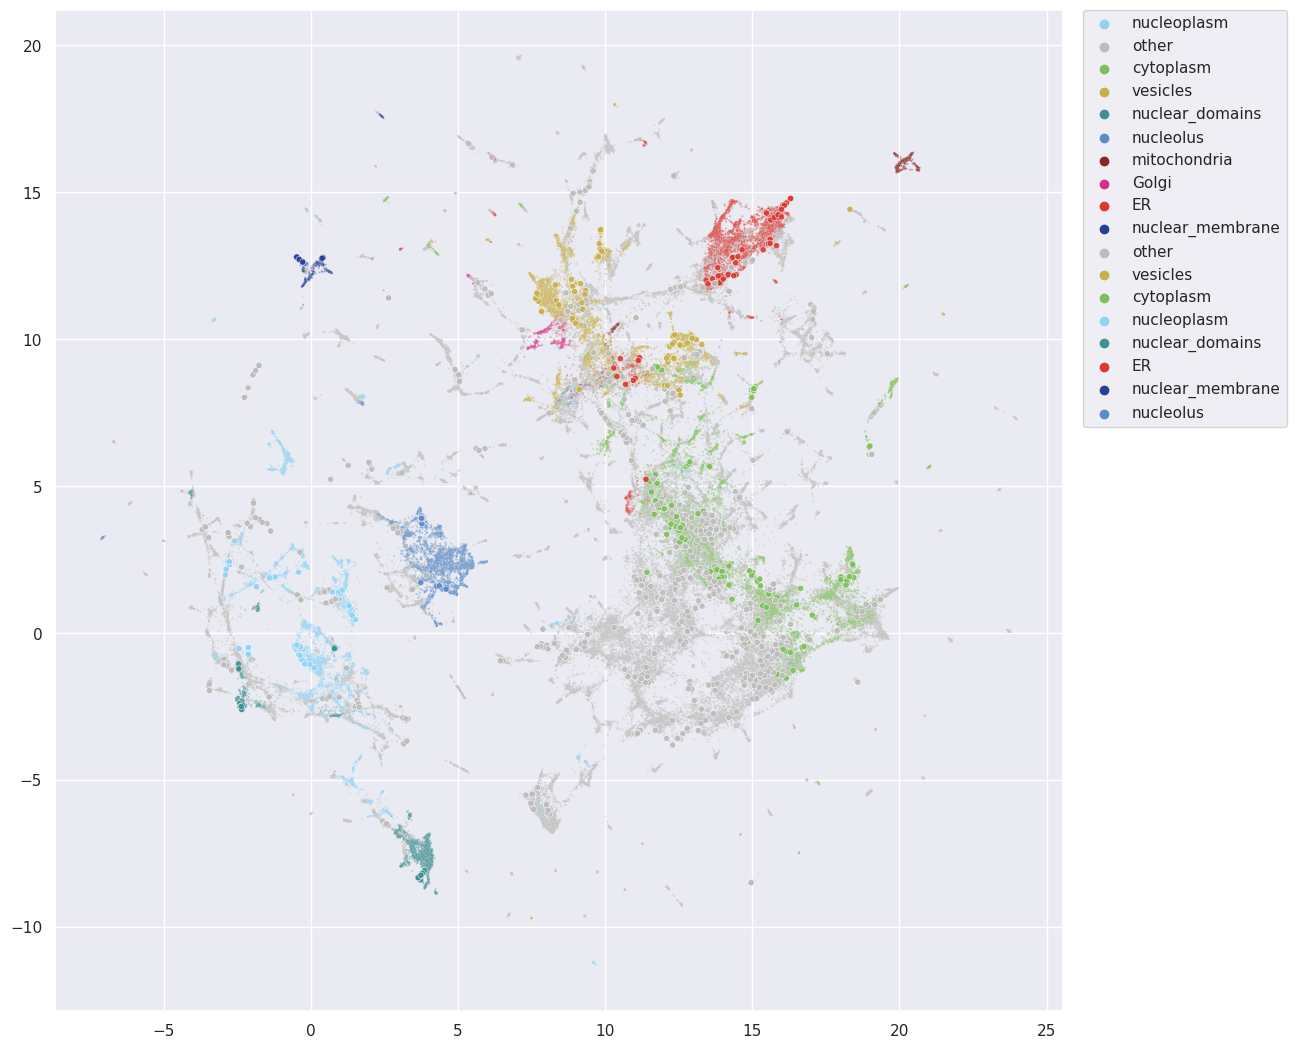

In [53]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_input_cytoself_embeds[:, 0], y=reduced_input_cytoself_embeds[:, 1], hue=true_localizations, s=20, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

## FCD scores with cyostelf

In [54]:
def compute_latent_statistics(latents, classes=None, all_classes=None):
    latents = latents.reshape(latents.shape[0], -1)

    if classes is None:
        latent_mean = np.mean(latents, axis=0)
        latent_cov = np.cov(latents, rowvar=False)
    else:
        if all_classes is None:
            all_classes = np.unique(classes)

        latent_mean = np.array([np.mean(latents[classes == c], axis=0) for c in all_classes])
        latent_cov = np.array([np.cov(latents[classes == c], rowvar=False) for c in all_classes])

    return {'mean': latent_mean, 'cov': latent_cov, 'class': all_classes}

In [55]:
from scipy.linalg import sqrtm


def frechet_distance(mu1, sigma1, mu2, sigma2):
    """
    Compute the Fréchet distance between two multivariate Gaussian distributions.
    """
    mean_diff = mu1 - mu2
    mean_diff_squared = mean_diff.dot(mean_diff)
    cov_mean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    trace_term = np.trace(sigma1 + sigma2 - 2 * cov_mean)
    frechet_dist = mean_diff_squared + trace_term
    return frechet_dist

In [56]:
all_names = np.unique(true_names)
input_cytoself_stats = compute_latent_statistics(input_cytoself_embeds, true_names, all_names)
output_cytoself_stats = compute_latent_statistics(output_cytoself_embeds, true_names, all_names)

In [57]:
# zipped = zip(input_cytoself_stats['mean'], input_cytoself_stats['cov'], output_cytoself_stats['mean'], output_cytoself_stats['cov'])
# fcd_scores = np.array([frechet_distance(mu1, sigma1, mu2, sigma2) for mu1, sigma1, mu2, sigma2 in zipped])

In [58]:
# print(fcd_scores.mean())
# print(fcd_scores.std())

In [59]:
input_cytoself_stats_all = compute_latent_statistics(input_cytoself_embeds, None, None)
output_cytoself_stats_all = compute_latent_statistics(output_cytoself_embeds, None, None)

In [60]:
mu1, sigma1 = input_cytoself_stats_all['mean'], input_cytoself_stats_all['cov']
mu2, sigma2 = output_cytoself_stats_all['mean'], output_cytoself_stats_all['cov']
fcd_score_all = frechet_distance(mu1, sigma1, mu2, sigma2)
print(fcd_score_all)

82.81487336015793


## Medians

In [61]:
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Generate sample data
n = input_cytoself_stats['mean'].shape[0]
Set_A = input_cytoself_stats['mean'].copy()
Set_B = output_cytoself_stats['mean'].copy()

# Compute pairwise distances for given pairs
given_pair_dists = np.array([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

# Compute pairwise distances for random pairs (1000 times)
random_pair_dists = []
np.random.seed(0)
for _ in range(1000):
    np.random.shuffle(Set_B)
    random_pair_dists.extend([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

# Statistical comparison
_, p_value = mannwhitneyu(given_pair_dists, random_pair_dists)
print(f"P-value: {p_value}")

P-value: 9.386362078270369e-09


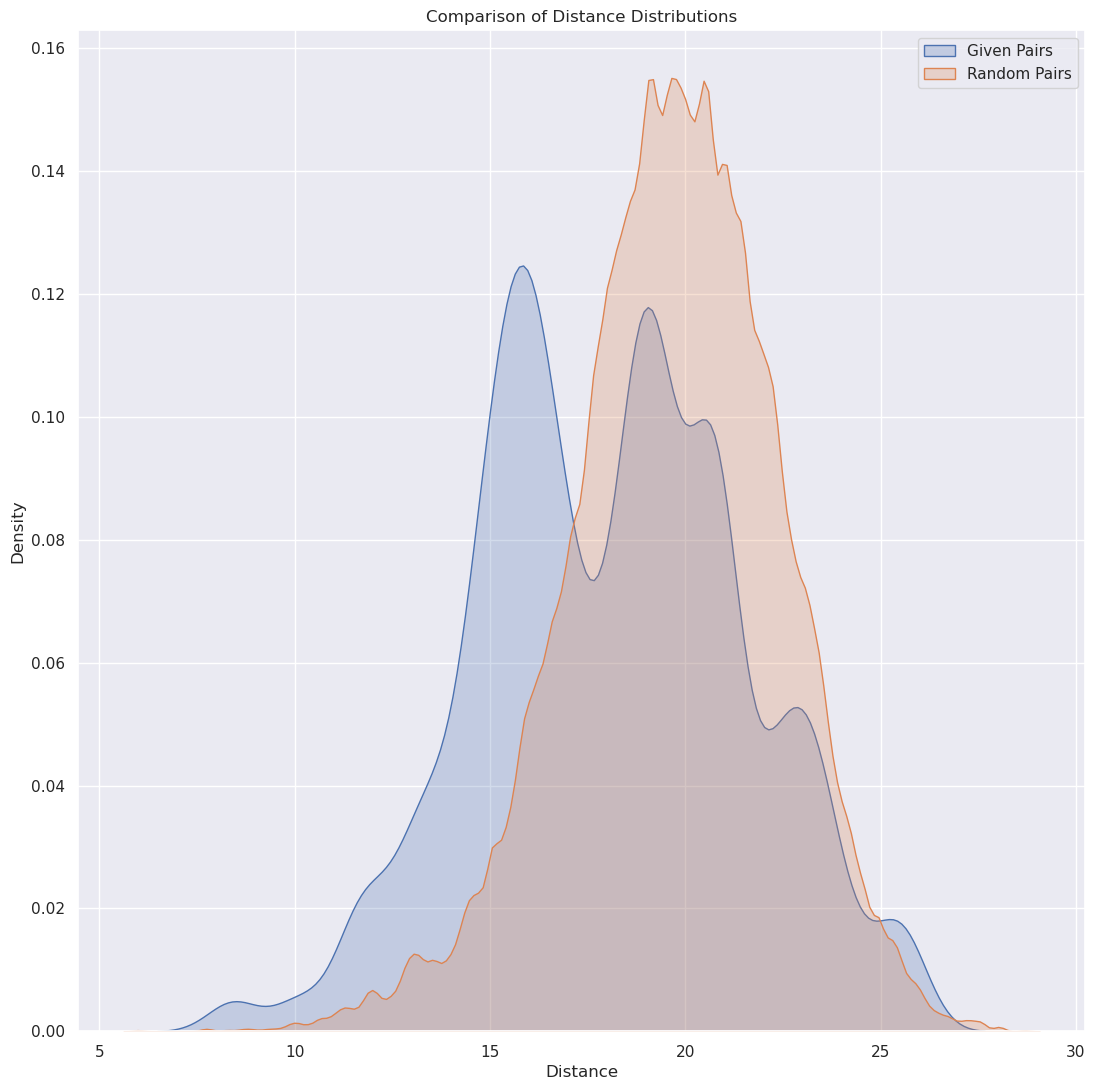

In [62]:
# Visualization
sns.kdeplot(given_pair_dists, label="Given Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
sns.kdeplot(random_pair_dists, label="Random Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Comparison of Distance Distributions")
plt.show()

In [63]:
print(np.mean(given_pair_dists))
print(np.mean(random_pair_dists))

18.072554406318957
19.668287757312978


In [64]:
thresh = 16
print(all_names[given_pair_dists < thresh])

['AGAP1' 'AKAP13' 'AMBRA1' 'ANKRD28' 'ARFGAP2' 'ASS1' 'BET1L' 'CD9' 'CHM'
 'DDX47' 'DNM1' 'ERI3' 'FASN' 'FAU' 'FXR1' 'HEATR3' 'KLC2' 'LDHB' 'MDH1'
 'OST4' 'PPP2CB' 'PSMB1' 'PSMB7' 'RABGGTA' 'RANBP9' 'SLC23A2' 'SLC27A4'
 'SLC5A6' 'SNF8' 'SNX17' 'STAM' 'STX10' 'SYVN1' 'TPT1' 'TUBA1B' 'UFC1'
 'VAPB' 'VPS29' 'WDR46' 'YKT6' 'YWHAH']


## Run localization classifier

In [65]:
from joblib import load

# Load the model from the file
clf = load(join(datapath, f'cytoself_{protein_split}localization_classifier.joblib'))

In [66]:
other = true_localizations == 'other'
X_test = input_cytoself_embeds[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = true_localizations[~other]

In [67]:
y_predict = clf.predict(X_test)

In [68]:
y_predict_scores = clf.predict_proba(X_test)

In [69]:
y_test_indices = np.searchsorted(clf.classes_, y_test)
true_labels_for_loc = true_labels[~other]
input_localization_classification_scores = [top_k_accuracy(y_test_indices, y_predict_scores, k=k) for k in range(1, num_avg)]
input_localization_class_scores_avg = [average_logits_prediction(true_labels_for_loc, y_test_indices, y_predict_scores, M=k) for k in range(1, num_avg)]

In [70]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.9529702970297029


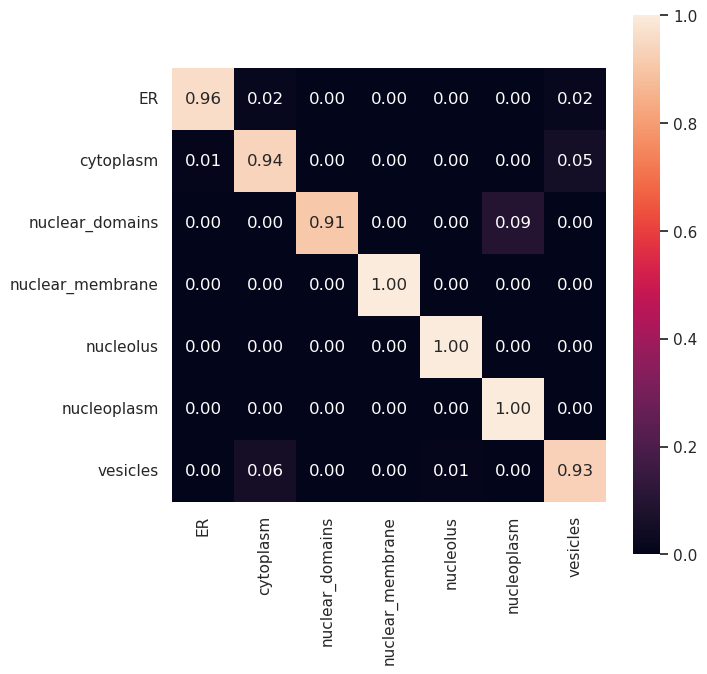

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");


In [72]:
other = true_localizations == 'other'
X_test = output_cytoself_embeds[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = true_localizations[~other]

In [73]:
y_predict = clf.predict(X_test)

In [74]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.5321782178217822


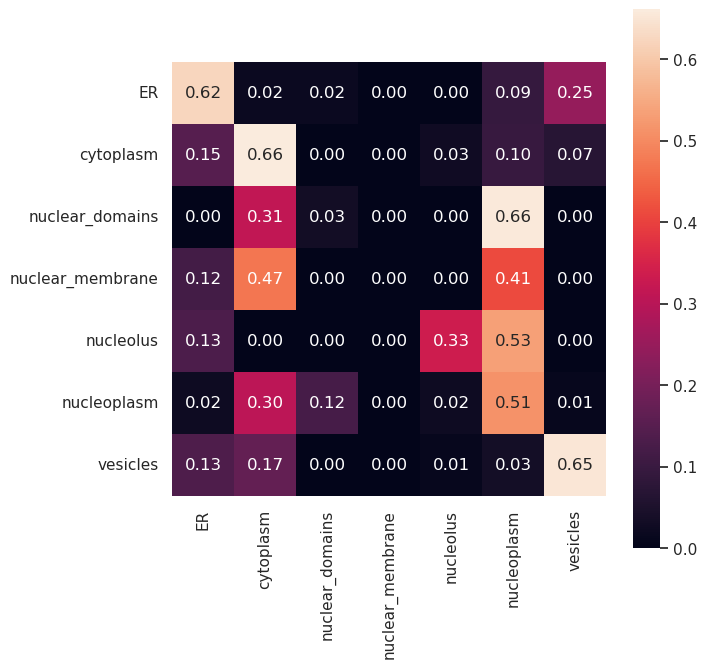

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");


In [76]:
y_predict_scores = clf.predict_proba(X_test)

In [77]:
true_labels_for_loc = true_labels[~other]
output_localization_classification_scores = [top_k_accuracy(y_test_indices, y_predict_scores, k=k) for k in range(1, num_avg)]
output_localization_class_scores_avg = [average_logits_prediction(true_labels_for_loc, y_test_indices, y_predict_scores, M=k) for k in range(1, num_avg)]

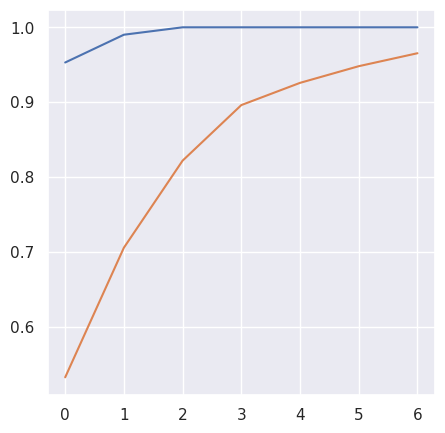

In [78]:
plt.figure(figsize=(5, 5))
plt.plot(input_localization_classification_scores);
plt.plot(output_localization_classification_scores);

In [79]:
print(input_localization_classification_scores[0])
print(output_localization_classification_scores[0])

print(input_localization_classification_scores[2])
print(output_localization_classification_scores[2])

0.9529702970297029
0.5321782178217822
1.0
0.8217821782178217


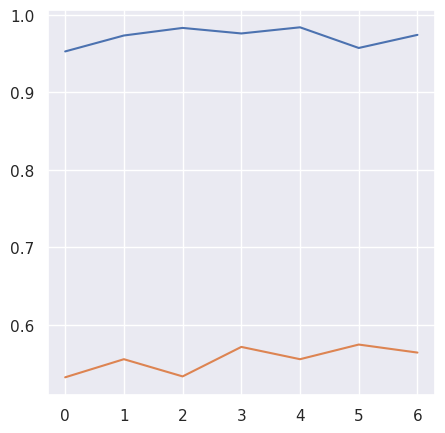

In [80]:
plt.figure(figsize=(5, 5))
plt.plot(input_localization_class_scores_avg);
plt.plot(output_localization_class_scores_avg);

In [81]:
print(input_localization_class_scores_avg[-1])
print(output_localization_class_scores_avg[-1])

0.9743589743589743
0.5641025641025641


## Autoencoder

In [82]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer_autoencoder = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer_autoencoder.fit(input_autoencoder_embeds.reshape(input_autoencoder_embeds.shape[0], -1))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [83]:
from joblib import dump
from joblib import load

dump(reducer_autoencoder, join(datapath,'autoencoder_umap_model.joblib'))

# reducer = load(join(datapath,'autoencoder_umap_model.joblib'))

['/home/ec2-user/cytoself-data/results/autoencoder_umap_model.joblib']

In [84]:
reduced_autoencoder_latent = reducer_autoencoder.transform(input_autoencoder_embeds.reshape(input_autoencoder_embeds.shape[0], -1))

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

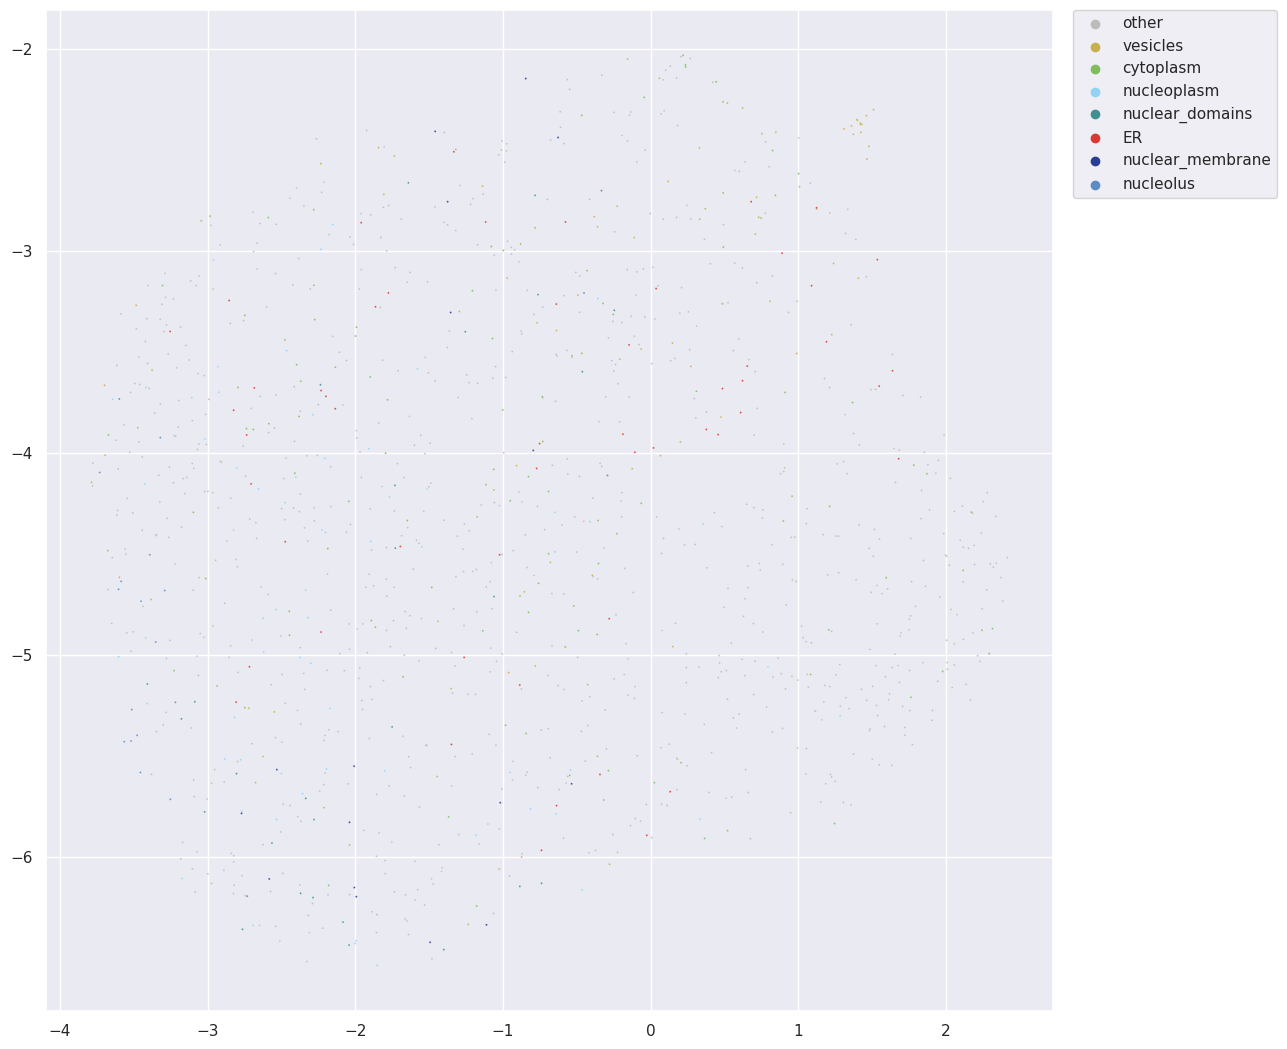

In [87]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_autoencoder_latent[:, 0], y=reduced_autoencoder_latent[:, 1], hue=true_localizations, s=2, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);